# Introduction

This notebook compares the test set performance of classifiers using term list scores based on the data-driven, RDoC, and DSM frameworks.

# Load the data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import sys
sys.path.append("..")
import utilities, evaluation
from style import style 

%matplotlib inline

## Input parameters

In [2]:
clf = "lr"
n_iter = 1000 # Number of iterations for bootstrap distributions

In [3]:
frameworks = ["data-driven", "rdoc", "dsm"]
names = {"data-driven": "Data-Driven", "rdoc": "RDoC", "dsm": "DSM"}
metrics = ["rocauc", "f1"]
directions = ["forward", "reverse"]

## Bootstrap distributions

In [4]:
obs, boot, null = {}, {}, {}
for fw in frameworks:
    obs[fw], boot[fw], null[fw] = {"name": names[fw]}, {"name": names[fw]}, {"name": names[fw]}
    for m in metrics:
        obs[fw][m], boot[fw][m], null[fw][m] = {}, {}, {}
        for d in directions:
            boot_file = "logistic_regression/data/{}_boot_{}_{}_{}iter.csv".format(m, fw, d, n_iter)
            boot[fw][m][d] = pd.read_csv(boot_file, index_col=0, header=0)
            null_file = "logistic_regression/data/{}_null_{}_{}_{}iter.csv".format(m, fw, d, n_iter)
            null[fw][m][d] = pd.read_csv(null_file, index_col=0, header=0)
            obs_file = "logistic_regression/data/{}_obs_{}_{}.csv".format(m, fw, d)
            obs[fw][m][d] = pd.read_csv(obs_file, index_col=0, header=None)

In [5]:
obs["data-driven"]["rocauc"]["forward"].mean()

1    0.609567
dtype: float64

In [6]:
obs["data-driven"]["rocauc"]["reverse"].mean()

1    0.710571
dtype: float64

# Perform comparison tests

Is the mean of fw<sub>i</sub> greater than the mean of fw<sub>j</sub>?

In [7]:
from statsmodels.stats.multitest import multipletests

In [8]:
fdr, sig = {}, {}
for metric in metrics:
    fdr[metric], sig[metric] = {}, {}
    for direction in directions:
        
        p = np.empty((len(frameworks), len(frameworks)))
        for i, fw_i in enumerate(frameworks):
            for j, fw_j in enumerate(frameworks):
                boot_i = np.mean(boot[fw_i][metric][direction], axis=0)
                boot_j = np.mean(boot[fw_j][metric][direction], axis=0)
                p[i,j] = np.sum((boot_i - boot_j) <= 0.0) / float(n_iter)
        
        fdr_md = multipletests(p.ravel(), method="fdr_bh")[1].reshape(p.shape)
        fdr_md = pd.DataFrame(fdr_md, index=frameworks, columns=frameworks)
        fdr[metric][direction] = fdr_md

In [9]:
interval = 0.999
tail = (1.0 - interval) / 2.0 # Two-sided test
idx_lower = int(n_iter * tail)
idx_upper = int(n_iter * (1.0 - tail))

CI = {}
for metric in metrics:
    CI[metric] = {}
    for direction in directions:
        
        CI[metric][direction] = pd.DataFrame("", index=frameworks, columns=frameworks)
        for i, fw_i in enumerate(frameworks):
            for j, fw_j in enumerate(frameworks):
                boot_i = np.mean(boot[fw_i][metric][direction], axis=0)
                boot_j = np.mean(boot[fw_j][metric][direction], axis=0)
                boot_dif = np.sort(boot_i - boot_j)
                CI_lower = boot_dif[idx_lower]
                CI_upper = boot_dif[idx_upper]
                CI_sig = ""
                if (CI_lower > 0 and CI_upper > 0) or (CI_lower < 0 and CI_upper < 0):
                    CI_sig = "*"
                CI[metric][direction].loc[fw_i,fw_j] = "{:.3f}, {:.3f} {}".format(CI_lower, CI_upper, CI_sig)

# Plot evaluation metrics

In [10]:
def plot_framework_comparison(metric, direction, boot, n_iter=1000,
                              dx=0.38, ylim=[0.4,0.65], yticks=[], font=style.font):
    
    import matplotlib.pyplot as plt
    from matplotlib import font_manager, rcParams

    font_prop = font_manager.FontProperties(fname=font, size=22)
    rcParams["axes.linewidth"] = 1.5
    
    fig = plt.figure(figsize=(1.6,2.2))#plt.figure(figsize=(2.6,3.2))
    ax = fig.add_axes([0,0,1,1])

    i = 0
    labels = []
    for fw, dist in boot.items():
        labels.append(dist["name"])
        dist = dist[metric][direction]
        dist_avg = np.mean(dist, axis=0)
        macro_avg = np.mean(dist_avg)
        plt.plot([i-dx, i+dx], [macro_avg, macro_avg], 
                 c="gray", alpha=1, lw=2, zorder=-1)
        v = ax.violinplot(sorted(dist_avg), positions=[i], 
                          showmeans=False, showmedians=False, widths=0.85)
        for pc in v["bodies"]:
            pc.set_facecolor("gray")
            pc.set_edgecolor("gray")
            pc.set_linewidth(2)
            pc.set_alpha(0.5)
        for line in ["cmaxes", "cmins", "cbars"]:
            v[line].set_edgecolor("none")
        i += 1

    ax.set_xticks(range(len(boot.keys())))
    ax.set_xticklabels(labels, rotation=60, ha="right")
    plt.xticks(fontproperties=font_prop)
    plt.yticks(yticks, fontproperties=font_prop)
    plt.xlim([-0.75, len(boot.keys())-0.25])
    plt.ylim(ylim)
    for side in ["right", "top"]:
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(width=1.5, length=7)
    ax.yaxis.set_tick_params(width=1.5, length=7)
    plt.savefig("logistic_regression/figures/{}_{}_{}iter.png".format(metric, direction, n_iter), 
                dpi=250, bbox_inches="tight")
    plt.show()

## ROC-AUC

----------------------------------------
		FORWARD
----------------------------------------
                  data-driven              rdoc             dsm
data-driven     0.000, 0.000     0.020, 0.049 *  0.055, 0.091 *
rdoc         -0.049, -0.020 *     0.000, 0.000   0.024, 0.058 *
dsm          -0.091, -0.055 *  -0.058, -0.024 *   0.000, 0.000 



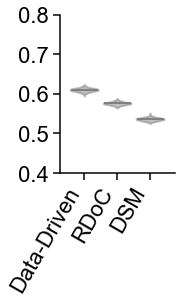

----------------------------------------
		REVERSE
----------------------------------------
                  data-driven            rdoc             dsm
data-driven     0.000, 0.000   0.019, 0.073 *  0.032, 0.111 *
rdoc         -0.073, -0.019 *   0.000, 0.000   -0.010, 0.070 
dsm          -0.111, -0.032 *  -0.070, 0.010    0.000, 0.000 



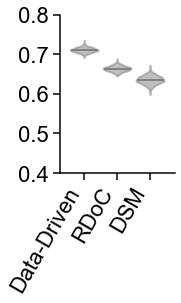

In [11]:
metric = "rocauc"
for direction in directions:
    print("-"*40 + "\n\t\t" + direction.upper() + "\n" + "-"*40)
    print(CI[metric][direction])
    print("")
    plot_framework_comparison(metric, direction, boot, n_iter=n_iter, 
                              ylim=[0.4,0.8], 
                              yticks=[0.4,0.5,0.6,0.7,0.8])

## F1 score

----------------------------------------
		FORWARD
----------------------------------------
                  data-driven              rdoc             dsm
data-driven     0.000, 0.000     0.015, 0.022 *  0.042, 0.051 *
rdoc         -0.022, -0.015 *     0.000, 0.000   0.024, 0.031 *
dsm          -0.051, -0.042 *  -0.031, -0.024 *   0.000, 0.000 



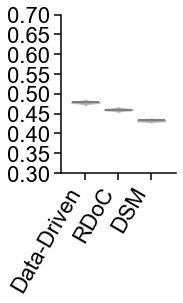

----------------------------------------
		REVERSE
----------------------------------------
                  data-driven              rdoc             dsm
data-driven     0.000, 0.000     0.040, 0.083 *  0.126, 0.164 *
rdoc         -0.083, -0.040 *     0.000, 0.000   0.063, 0.096 *
dsm          -0.164, -0.126 *  -0.096, -0.063 *   0.000, 0.000 



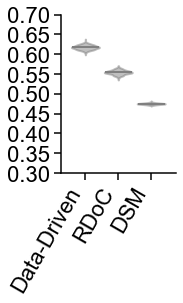

In [12]:
metric = "f1"
for direction in directions:
    print("-"*40 + "\n\t\t" + direction.upper() + "\n" + "-"*40)
    print(CI[metric][direction])
    print("")
    plot_framework_comparison(metric, direction, boot, n_iter=n_iter, 
                              ylim=[0.3,0.7], yticks=[0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7])

# Difference maps 

In [13]:
%matplotlib inline

In [14]:
alpha = 0.001
dif_thres = {}
for fw in ["rdoc", "dsm"]:
    dif_thres[fw] = {}
    for metric in ["rocauc", "f1"]:
        dif_null = null["data-driven"][metric]["forward"] - null[fw][metric]["forward"]
        dif_obs = obs["data-driven"][metric]["forward"] - obs[fw][metric]["forward"]
        pvals = [np.sum(np.abs(dif_null.values[i,:]) > np.abs(dif_obs.values[i])) / n_iter for i in range(len(dif_obs))]
        fdrs = multipletests(pvals, method="fdr_bh")[1]
        dif_obs[fdrs >= alpha] = np.nan
        dif_thres[fw][metric] = dif_obs
        dif_thres[fw][metric].columns = [""]

In [15]:
atlas = utilities.load_atlas()

/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
def map_plane(estimates, atlas, path, suffix="", plane="z", cbar=False, 
              vmin=None, vmax=None, cmaps=[], print_fig=True, verbose=False):
    from nilearn import image, plotting
    for f, feature in enumerate(estimates.columns):
        stat_map = image.copy_img(atlas).get_data()
        data = estimates[feature]
        if verbose:
            print("{:20s} Min: {:6.4f}  Mean: {:6.4f}  Max: {:6.4f}".format(
                  feature, min(data), np.mean(data), max(data)))
        for i, value in enumerate(data):
            stat_map[stat_map == i+1] = value
        stat_map = image.new_img_like(atlas, stat_map)
        display = plotting.plot_stat_map(stat_map,
                                         display_mode=plane, 
                                         symmetric_cbar=False, colorbar=False,
                                         cmap=cmaps[f], threshold=vmin, 
                                         vmax=vmax, alpha=0.5,
                                         annotate=False, draw_cross=False)
        file_name = "{}/{}{}.png".format(path, feature, suffix)
        display.savefig(file_name, dpi=250)
        utilities.transparent_background(file_name)
        display.close()
        if print_fig:
            display = plotting.plot_stat_map(stat_map,
                                             display_mode=plane, 
                                             symmetric_cbar=False, colorbar=cbar,
                                             cmap=cmaps[f], threshold=vmin, 
                                             vmax=vmax, alpha=0.5,
                                             annotate=True, draw_cross=False)
            plotting.show()

In [17]:
def map_fw_dif(fw, metric, vmax=None):
    map_plane(dif_thres[fw][metric], atlas, "logistic_regression/figures", 
              suffix="{}_dif_{}_{}iter".format(metric, fw, n_iter), 
              plane="ortho", cbar=True, vmin=0, vmax=vmax, 
              cmaps=["RdBu_r"], print_fig=True, verbose=False)

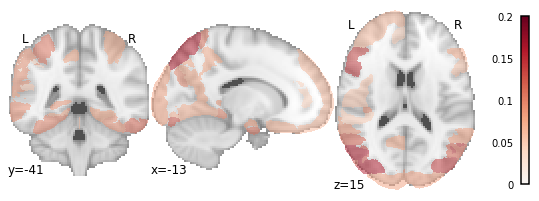

In [18]:
map_fw_dif("rdoc", "rocauc", vmax=0.2)

In [19]:
df = dif_thres["rdoc"]["rocauc"]
df.columns = ["dif"]
df.sort_values(["dif"],ascending=False)[:10]

,dif
0,
left_lateral_occipital_cortex_superior_division,0.157975
left_inferior_temporal_gyrus_temporooccipital_part,0.151093
left_middle_frontal_gyrus,0.145128
left_inferior_frontal_gyrus_pars_opercularis,0.145126
right_lateral_occipital_cortex_superior_division,0.140853
left_inferior_frontal_gyrus_pars_triangularis,0.137196
right_parahippocampal_gyrus_posterior_division,0.135539
left_lateral_occipital_cortex_inferior_division,0.128472
left_occipital_fusiform_gyrus,0.125387


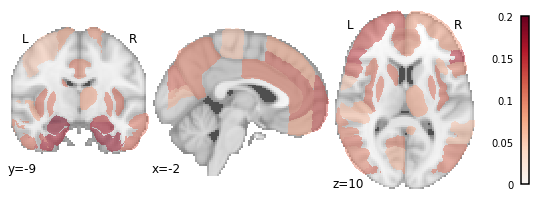

In [20]:
map_fw_dif("dsm", "rocauc", vmax=0.2)

In [21]:
df = dif_thres["dsm"]["rocauc"]
df.columns = ["dif"]
df.sort_values(["dif"],ascending=False)[:20]

,dif
0,
left_amygdala,0.186046
left_hippocampus,0.177622
right_parahippocampal_gyrus_anterior_division,0.176870
right_temporal_fusiform_cortex_posterior_division,0.172147
right_parahippocampal_gyrus_posterior_division,0.165760
left_frontal_orbital_cortex,0.165750
left_parahippocampal_gyrus_anterior_division,0.165502
right_hippocampus,0.163868
left_temporal_fusiform_cortex_anterior_division,0.163537


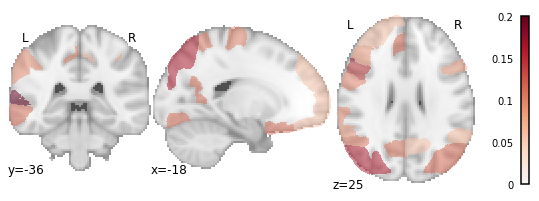

In [22]:
map_fw_dif("rdoc", "f1", vmax=0.2)

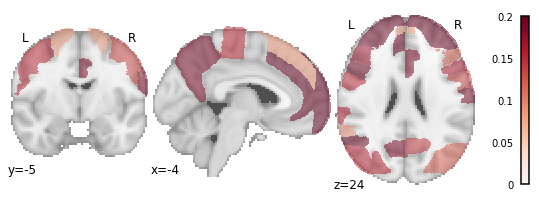

In [23]:
map_fw_dif("dsm", "f1", vmax=0.2)